In [13]:
#from google.colab import files
#files.upload()  # upload kaggle.json here


In [4]:
# 📌 Upload your kaggle.json API key manually from the left panel
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 📌 Install Kaggle API
!pip install -q kaggle

In [7]:
# 📌 Download only the necessary files from the competition
!kaggle competitions download -c siim-isic-melanoma-classification -f train.csv
!kaggle competitions download -c siim-isic-melanoma-classification -f test.csv
!kaggle competitions download -c siim-isic-melanoma-classification -f sample_submission.csv


  0% 0.00/339k [00:00<?, ?B/s]
100% 339k/339k [00:00<00:00, 583MB/s]
  0% 0.00/479k [00:00<?, ?B/s]
100% 479k/479k [00:00<00:00, 616MB/s]
  0% 0.00/161k [00:00<?, ?B/s]
100% 161k/161k [00:00<00:00, 354MB/s]


In [17]:
!unzip -q train.csv -d train

replace train/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [18]:
# EDA

#Import and Basic Setup

# 📦 Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📥 Load CSV files
train_df = pd.read_csv('/content/train/train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')


In [22]:
# 📌 Shape of the datasets

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Sample submission shape:", sample_submission.shape)

# 🔍 Preview first rows
train_df.head()


Train shape: (33126, 8)
Test shape: (10982, 5)
Sample submission shape: (10982, 2)


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [23]:
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [29]:
# Check for Missing Values

# 🧼 Missing values in training set
print("Missing value:\n", train_df.isnull().sum())


Missing value:
 image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64


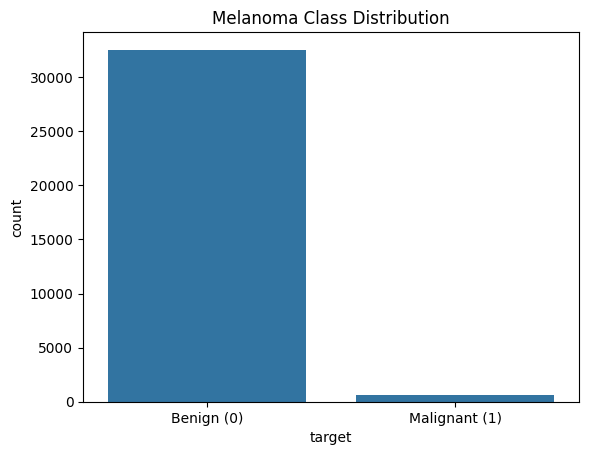

Malignant Melanoma Ratio: 0.0176 (1.76%)


In [30]:
# Target Distribution

# ⚠️ Melanoma class distribution
sns.countplot(x='target', data=train_df)
plt.title("Melanoma Class Distribution")
plt.xticks([0, 1], ['Benign (0)', 'Malignant (1)'])
plt.show()

# 🔢 Percentage of malignant cases
malignant_ratio = train_df['target'].mean()
print(f"Malignant Melanoma Ratio: {malignant_ratio:.4f} ({malignant_ratio * 100:.2f}%)")


Unique patient IDs: 2056


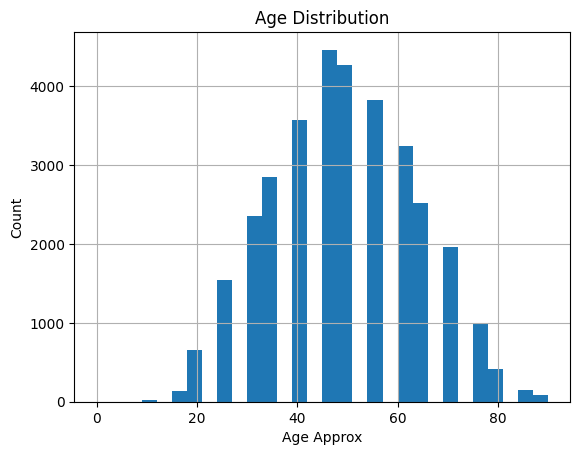

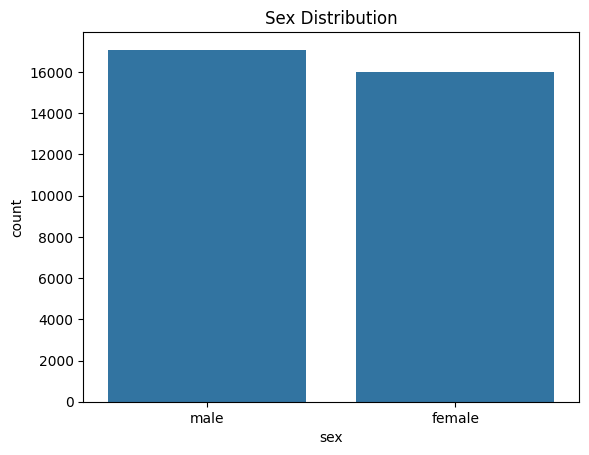

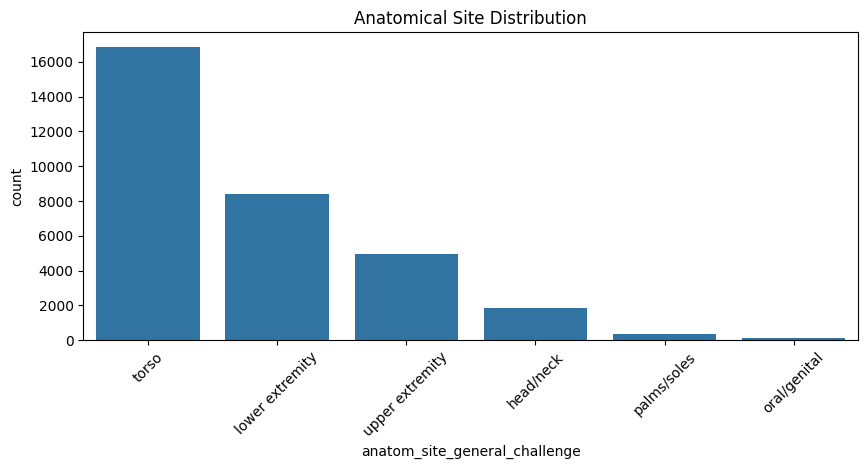

In [31]:
# Patient & Metadata Analysis

# 🧑‍🤝‍🧑 Unique patients
print("Unique patient IDs:", train_df['patient_id'].nunique())

# 🧓 Age distribution
train_df['age_approx'].hist(bins=30)
plt.title("Age Distribution")
plt.xlabel("Age Approx")
plt.ylabel("Count")
plt.show()

# 🚻 Sex distribution
sns.countplot(x='sex', data=train_df)
plt.title("Sex Distribution")
plt.show()

# 📍 Anatomical site
plt.figure(figsize=(10, 4))
sns.countplot(data=train_df, x='anatom_site_general_challenge', order=train_df['anatom_site_general_challenge'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Anatomical Site Distribution")
plt.show()


In [32]:
# Fill missing categorical data with 'unknown'
train_df['sex'].fillna('unknown', inplace=True)
train_df['anatom_site_general_challenge'].fillna('unknown', inplace=True)

# Fill missing age with median value
train_df['age_approx'].fillna(train_df['age_approx'].median(), inplace=True)


/tmp/ipython-input-32-2848572909.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['sex'].fillna('unknown', inplace=True)
/tmp/ipython-input-32-2848572909.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [33]:
# 🔍 Check again for missing values
train_df.isnull().sum()


,0
image_name,0
patient_id,0
sex,0
age_approx,0
anatom_site_general_challenge,0
diagnosis,0
benign_malignant,0
target,0


In [36]:
# Label encoding

from sklearn.preprocessing import LabelEncoder

le_sex = LabelEncoder()
le_anatom = LabelEncoder()

train_df['sex_encoded'] = le_sex.fit_transform(train_df['sex'])
train_df['anatom_site_encoded'] = le_anatom.fit_transform(train_df['anatom_site_general_challenge'])


In [35]:
# Features and Target

features = ['age_approx', 'sex_encoded', 'anatom_site_encoded']
X = train_df[features]
y = train_df['target']


In [37]:
# Model Training: Logistic Regression (Baseline)

# 📦 Model and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 📊 Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ⚖️ Handle class imbalance with class_weight='balanced'
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# 📈 Predict and evaluate
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

print("📌 Classification Report:\n", classification_report(y_val, y_pred))
print("📌 ROC-AUC Score:", roc_auc_score(y_val, y_proba))


📌 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.61      0.76      6509
           1       0.03      0.62      0.05       117

    accuracy                           0.61      6626
   macro avg       0.51      0.62      0.41      6626
weighted avg       0.97      0.61      0.75      6626

📌 ROC-AUC Score: 0.660833192174412


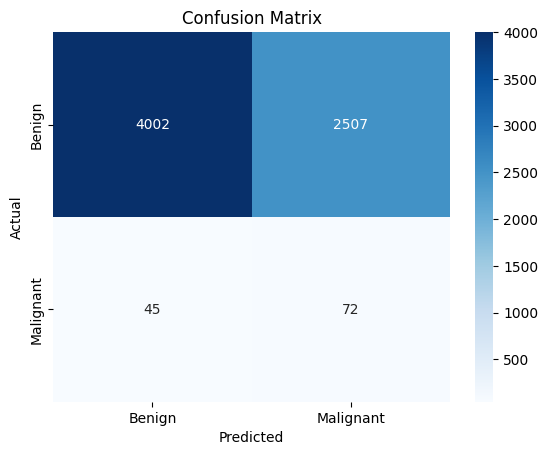

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [39]:
# Stornger Model RandomForest

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_val)
y_proba_rf = rf_model.predict_proba(X_val)[:, 1]

print("📌 Classification Report (RF):\n", classification_report(y_val, y_pred_rf))
print("📌 ROC-AUC Score (RF):", roc_auc_score(y_val, y_proba_rf))


📌 Classification Report (RF):
               precision    recall  f1-score   support

           0       0.99      0.74      0.85      6509
           1       0.03      0.41      0.05       117

    accuracy                           0.74      6626
   macro avg       0.51      0.58      0.45      6626
weighted avg       0.97      0.74      0.83      6626

📌 ROC-AUC Score (RF): 0.6265926337365884


In [40]:
# Install imbalanced-learn if not already installed
!pip install -q imbalanced-learn


In [41]:
# Oversampling with SMOTE

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Split original data
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest on balanced data
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred = rf_smote.predict(X_val)
y_proba = rf_smote.predict_proba(X_val)[:, 1]

print("📌 Classification Report (SMOTE):\n", classification_report(y_val, y_pred))
print("📌 ROC-AUC Score (SMOTE):", roc_auc_score(y_val, y_proba))


📌 Classification Report (SMOTE):
               precision    recall  f1-score   support

           0       0.99      0.74      0.84      6509
           1       0.03      0.41      0.05       117

    accuracy                           0.73      6626
   macro avg       0.51      0.57      0.45      6626
weighted avg       0.97      0.73      0.83      6626

📌 ROC-AUC Score (SMOTE): 0.6243373737612483


In [42]:
# Or Random Undersampling

from imblearn.under_sampling import RandomUnderSampler

# Apply Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Train model
rf_rus = RandomForestClassifier(random_state=42)
rf_rus.fit(X_rus, y_rus)

# Evaluate
y_pred_rus = rf_rus.predict(X_val)
y_proba_rus = rf_rus.predict_proba(X_val)[:, 1]

print("📌 Classification Report (Undersampling):\n", classification_report(y_val, y_pred_rus))
print("📌 ROC-AUC Score (Undersampling):", roc_auc_score(y_val, y_proba_rus))


📌 Classification Report (Undersampling):
               precision    recall  f1-score   support

           0       0.99      0.67      0.80      6509
           1       0.03      0.52      0.05       117

    accuracy                           0.67      6626
   macro avg       0.51      0.60      0.43      6626
weighted avg       0.97      0.67      0.79      6626

📌 ROC-AUC Score (Undersampling): 0.6348369712941844


In [55]:
from sklearn.preprocessing import LabelEncoder

# Encode 'diagnosis'
le_diagnosis = LabelEncoder()
train_df['diagnosis_encoded'] = le_diagnosis.fit_transform(train_df['diagnosis'])

# Encode 'benign_malignant'
train_df['malignant_flag'] = train_df['benign_malignant'].map({'benign': 0, 'malignant': 1})


In [56]:
#Final feature set

features = ['age_approx', 'sex_encoded', 'anatom_site_encoded', 'diagnosis_encoded', 'malignant_flag']
X = train_df[features]
y = train_df['target']


In [57]:
# New Logistic Regression Training (class_weight=‘balanced’)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_val)
y_proba = logreg.predict_proba(X_val)[:, 1]

# Results
print("📌 Classification Report:\n", classification_report(y_val, y_pred))
print("📌 ROC-AUC Score:", roc_auc_score(y_val, y_proba))


📌 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6509
           1       1.00      1.00      1.00       117

    accuracy                           1.00      6626
   macro avg       1.00      1.00      1.00      6626
weighted avg       1.00      1.00      1.00      6626

📌 ROC-AUC Score: 1.0


In [58]:
# 🔍 Benign_malignant vs. Target
pd.crosstab(train_df['benign_malignant'], train_df['target'])

# 🔍 Diagnosis vs. Target
pd.crosstab(train_df['diagnosis'], train_df['target'])


target,0,1
diagnosis,,
atypical melanocytic proliferation,1,0
cafe-au-lait macule,1,0
lentigo NOS,44,0
lichenoid keratosis,37,0
melanoma,0,584
nevus,5193,0
seborrheic keratosis,135,0
solar lentigo,7,0
unknown,27124,0


**There is Data Leakage**<br>
According to the crosstab output you provided:

from the diagnosis column:

all samples with a melanoma diagnosis have **target=1**

all diagnoses with **target=0**

This indicates that the model is not performing a classification, but is using the label itself. This is a serious example of data leakage.

I will remove the following columns from the model:<br>
diagnosis

benign_malignant (probably directly related)

In [59]:
# ⚠️ Drop leakage features
features = ['age_approx', 'sex_encoded', 'anatom_site_encoded']  # sadece gerçek anlamlı, sızıntısız veriler
X = train_df[features]
y = train_df['target']


In [60]:
# Training Again

# Split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

# Evaluate
print("📌 Classification Report:\n", classification_report(y_val, y_pred))
print("📌 ROC-AUC Score:", roc_auc_score(y_val, y_proba))


📌 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.61      0.76      6509
           1       0.03      0.62      0.05       117

    accuracy                           0.61      6626
   macro avg       0.51      0.62      0.41      6626
weighted avg       0.97      0.61      0.75      6626

📌 ROC-AUC Score: 0.660833192174412


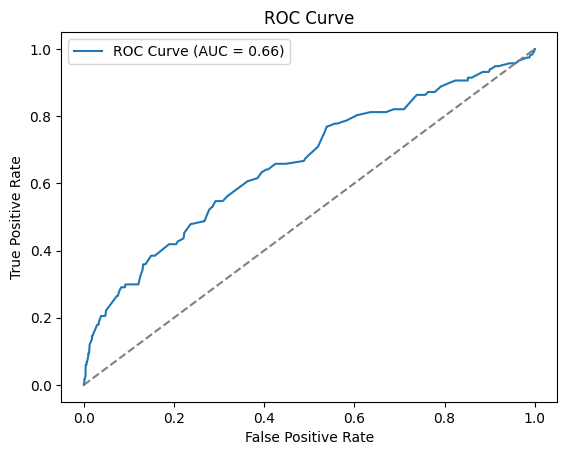

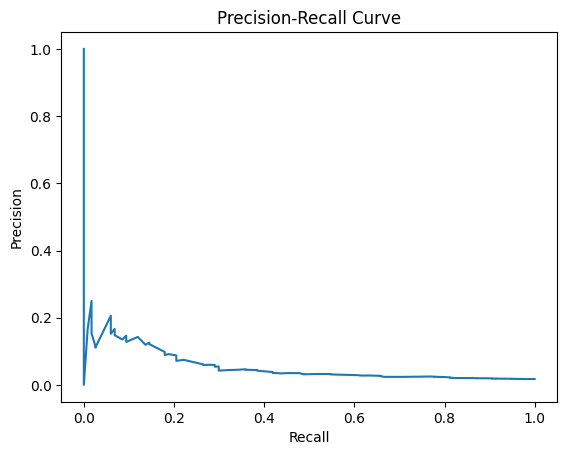

In [61]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_val, y_proba):.2f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_val, y_proba)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [62]:
import pickle

# 💾 Save model
with open('logreg_model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [63]:
# 📄 Load test data
test_df = pd.read_csv("test.csv")

# 🧼 Handle missing values
test_df['sex'].fillna('unknown', inplace=True)
test_df['anatom_site_general_challenge'].fillna('unknown', inplace=True)
test_df['age_approx'].fillna(train_df['age_approx'].median(), inplace=True)

# 🔢 Label encode using same encoders
test_df['sex_encoded'] = le_sex.transform(test_df['sex'])
test_df['anatom_site_encoded'] = le_anatom.transform(test_df['anatom_site_general_challenge'])

# 🎯 Final test features
X_test_final = test_df[['age_approx', 'sex_encoded', 'anatom_site_encoded']]


/tmp/ipython-input-63-2977207099.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['sex'].fillna('unknown', inplace=True)
/tmp/ipython-input-63-2977207099.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [64]:
# 🔮 Predict probabilities
test_preds = model.predict_proba(X_test_final)[:, 1]


In [65]:
# In a format suitable for the ready submission file
submission = pd.DataFrame({
    'image_name': test_df['image_name'],
    'target': test_preds
})

submission.to_csv('submission.csv', index=False)
submission.head()


,image_name,target
0,ISIC_0052060,0.687342
1,ISIC_0052349,0.425700
2,ISIC_0058510,0.451354
3,ISIC_0073313,0.403489
4,ISIC_0073502,0.372573
